In [68]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_curve
from sklearn.feature_selection import SelectFromModel


import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth',None)

In [2]:
#read in text
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv('SMSSpamCollection.tsv',sep='\t',header=None)
data.columns = ['label','sms_text']
data['label_num']= data['label'].map({'ham': 0,'spam':1})

In [3]:
#create func to remove punctuation, tokenize, remove stopwords,stem

stopword = nltk.corpus.stopwords.words('english')
def clean_text (single_sms):
    #remove punctuation
    new_text = ''.join([char for char in single_sms if char not in string.punctuation])
    #tokenize sentence (will remove extra spaces as well)
    tokens = word_tokenize(new_text.lower())
    #remove stopwords and returned stemmed word
    new_text = [ps.stem(word) for word in tokens if word not in stopword]
    
    return new_text

In [4]:
#feature engineering

#length of text
def ret_len(text):
    return len(text)- text.count(' ')

data ['text_len'] = data['sms_text'].apply(ret_len)

#% of punctuation chars in a text
def ret_punc_per(text):
    punc_count = 0
    for char in text :
        if char in string.punctuation:
            punc_count += 1
            
    return round(punc_count/(len(text)- text.count(' ')),3)*100
data['punct%'] = data['sms_text'].apply(ret_punc_per)

#num of digits in a text
def ret_digit_per(text):
    digit_count = 0
    for char in text :
        if char.isdigit():
            digit_count += 1
            
    return round(digit_count/(len(text)- text.count(' ')),3)*100
data ['digit%'] = data['sms_text'].apply(ret_digit_per)

#percentage of capital letters:
def ret_upper_per(text):
    upper_count = 0
    for char in text :
        if char.isupper():
            upper_count += 1
            
    return round(upper_count/(len(text)- text.count(' ')),3)*100
data['upper%'] = data['sms_text'].apply(ret_upper_per)

def ret_url_presence(text):
   
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    if len(urls) == 0:
        #empty list, no url
        return 0
    else :
        return 1 #text has urls
data ['url_present'] = data['sms_text'].apply(ret_url_presence)


In [25]:
#Split data :

X_train, X_test, y_train, y_test = train_test_split(data[['sms_text','text_len','punct%','digit%','upper%','url_present']],data['label_num'],test_size=0.20, random_state=42)



In [26]:
#create vectorised dataset : convert sms_text col to a numeric form

#create vectorizer and pass clean func made above
tfid_vect = TfidfVectorizer(analyzer=clean_text)
tfid_vect_fit = tfid_vect.fit(X_train['sms_text'])

#create vectorised columns
tfid_train = tfid_vect_fit.transform(X_train['sms_text']) #sparse matrix
tfid_test = tfid_vect_fit.transform(X_test['sms_text']) #sparse matrix


new_train_df = X_train[['text_len','punct%','digit%','upper%','url_present']].reset_index(drop = True)
vect_train_df = pd.DataFrame(tfid_train.toarray()) #convert sparse matrix to array
vect_train_df.columns = tfid_vect.get_feature_names_out() #column names will be unique words 

new_test_df = X_test[['text_len','punct%','digit%','upper%','url_present']].reset_index(drop = True)
vect_test_df = pd.DataFrame(tfid_test.toarray()) #convert sparse matrix to array
vect_test_df.columns = tfid_vect.get_feature_names_out() #column names will be unique words 

X_train_vect = pd.concat([new_train_df,vect_train_df],axis=1)
X_test_vect = pd.concat([new_test_df,vect_test_df],axis=1)

In [31]:
X_train_vect.head()

,text_len,punct%,digit%,upper%,url_present,0,008704050406,0089mi,0121,01223585334,...,»,é,ü,üll,–,‘,’,“,…,…thank
0,94,6.4,2.1,3.2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104,5.8,1.9,3.8,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,6.1,0.0,4.1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39,2.6,0.0,2.6,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,4.5,0.0,4.5,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
#Create a benchmark for comparing performance

#oversample 
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_vect,y_train) #7285 cols

#apply model
rf = RandomForestClassifier(random_state=42,n_jobs=-1) #default setting

scores = cross_val_score(rf,X_resampled,y_resampled,cv = 5)
print(scores) #model is stable

start = time.time()
rf.fit(X_resampled,y_resampled)
end = time.time()
fit_time = end-start

start = time.time()
y_pred = rf.predict(X_test_vect) #7285 cols
end = time.time()
pred_time = end-start

print(f'fit time is {fit_time} and Prediction time is {pred_time}')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))


[1.         1.         0.99935191 1.         1.        ]
fit time is 1.3946611881256104 and Prediction time is 0.08587384223937988
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.89      0.94       149

    accuracy                           0.98      1114
   macro avg       0.99      0.94      0.97      1114
weighted avg       0.99      0.98      0.98      1114

[[965   0]
 [ 17 132]]
0.9429530201342282


In [83]:
#This value will be used as a threshold for selecting best features.
pd.Series(rf.feature_importances_).mean()

0.00013726835964310185

In [ ]:
'''
Interpret : 0 = ham, 1 = spam
    
            Predicted vals
                0         1
Actual vals 0   TP (965) FN(0)
            1   FP(17)   TN(132)
    
965 ham data points were correctly predicted to be ham
132 spam data points were correctly predicted to be spam
17 spam data points were incorrectly predicted to be ham
0 ham data points were correctly predicted to be spam. Good. No mis-cassification

for 1, spam :
prec = 1 , when model predicted sth as spam, it turned out to be spam.
recall = .89 , Of all sms that came to your phone, 89% were correctly put in spam folder. Balance 11% spam msgs
went to your inbox
accuracy = .98, Of all msgs that came to your phone, 98% of the time they were correctly identified as spam or ham.

we have scope to improve recall as 11% of spam is going to our inbox. use gridsearchcv to test different 
hyperparameters and make your model more aggressive.

'''

In [70]:
#Feature importance :

pd.Series(rf.feature_importances_,index = X_train_vect.columns).sort_values(ascending=False).head(10)

digit%      0.159032
text_len    0.076999
upper%      0.061914
call        0.027400
free        0.020468
claim       0.017640
mobil       0.016691
punct%      0.015814
txt         0.015457
text        0.013746
dtype: float64

<AxesSubplot:>

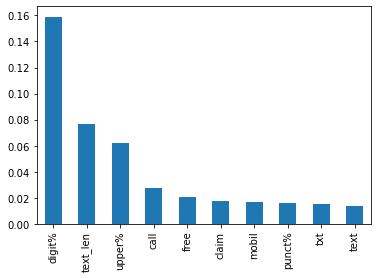

In [71]:
pd.Series(rf.feature_importances_,index = X_train_vect.columns).sort_values(ascending=False).head(10).plot(kind='bar')

In [ ]:
#Feature selection :

In [72]:
#Select best features : Select features whose feature importance is greater than or equal to the mean of feature
#importance of all features.

sel = SelectFromModel(RandomForestClassifier(random_state=42,n_jobs=-1)) #n_estimators = 100 is default
sel.fit(X_resampled, y_resampled)

selected_feat = X_resampled.columns[sel.get_support()]
print(len(selected_feat))
print(selected_feat)

642
Index(['text_len', 'punct%', 'digit%', 'upper%', 'url_present', '02070836089',
       '02073162414', '07090201529', '078', '0800',
       ...
       '£150', '£2000', '£250', '£300', '£3350', '£350', '£500', '£5000',
       '£75000', 'ü'],
      dtype='object', length=642)


In [11]:
X_train_vect.columns

Index(['text_len', 'punct%', 'digit%', 'upper%', 'url_present', '0',
       '008704050406', '0089mi', '0121', '01223585334',
       ...
       '»', 'é', 'ü', 'üll', '–', '‘', '’', '“', '…', '…thank'],
      dtype='object', length=7285)

In [12]:
#X Train data with best features
X_train_vect[selected_feat]

,text_len,punct%,digit%,upper%,url_present,02070836089,02073162414,07090201529,0800,08000839402,...,£2000,£250,£350,£400,£5,£500,£5000,£75000,£800,ü
0,94,6.4,2.1,3.2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104,5.8,1.9,3.8,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,6.1,0.0,4.1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39,2.6,0.0,2.6,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,4.5,0.0,4.5,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,102,4.9,0.0,16.7,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4450,105,2.9,1.9,2.9,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4451,24,8.3,0.0,8.3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4452,34,2.9,0.0,2.9,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
#Evaluate performance of the model with 642 best features as selected above :

#oversample 
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_vect[selected_feat],y_train) #642 cols

#apply model
rf = RandomForestClassifier(random_state=42,n_jobs=-1) #default : estimators = 100, max depth = None

scores = cross_val_score(rf,X_resampled,y_resampled,cv = 5)
print(scores) #model is stable

start = time.time()
rf.fit(X_resampled,y_resampled)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = rf.predict(X_test_vect[selected_feat]) #642 cols
end = time.time()
pred_time = end - start

print(f'fit time is {fit_time} and Prediction time is {pred_time}')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))

#Accuracy of 7285 cols is same as 642 cols.


[0.99935191 0.99870382 0.99935191 0.99870382 0.99935149]
fit time is 0.27860116958618164 and Prediction time is 0.026859045028686523
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1114
   macro avg       0.99      0.95      0.97      1114
weighted avg       0.98      0.98      0.98      1114

[[964   1]
 [ 16 133]]
0.9457905901171889


In [ ]:
'''
The column with the mean_test_score is the average of the scores on the test set for all the folds
during cross-validation.
'''

In [ ]:
#mean_fit_time : Avg time it takes each model to fit
#mean_score_time : Avg time a model takes to make a prediction on test set
#mean_test_score : Avg accuracy on the test set
#mean_train_score : Avg accuracy on the train set

In [75]:
%%time
#rfc, n estimator 100 is default, max_depth : None is default

#Gridsearch cv : to find best combination of hyperparameters :

rf = RandomForestClassifier(random_state=42,n_jobs=-1) 
params = {
    'n_estimators':[10,100,150,300],
    'max_depth':[20,30,60,90,None]
}

gs = GridSearchCV(rf,params,cv=5) #,n_jobs=-1
y_train_reset_i = y_train.reset_index(drop=True)
gs.fit(X_train_vect[selected_feat],y_train_reset_i) #650 columns

#top 5 models
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score',ascending=False)[:5]

CPU times: user 15.8 s, sys: 2.07 s, total: 17.8 s
Wall time: 58.9 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,0.727674,0.172173,0.026390,0.000749,None,150,"{'max_depth': None, 'n_estimators': 150}",0.985410,0.989899,0.988777,0.983165,0.982022,0.985855,0.003066,1
14,0.536376,0.192992,0.025556,0.000874,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.985410,0.989899,0.988777,0.983165,0.982022,0.985855,0.003066,1
5,0.306357,0.015040,0.019444,0.000418,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.983165,0.991021,0.988777,0.984287,0.982022,0.985855,0.003453,1
6,0.387434,0.014200,0.026959,0.000534,30,150,"{'max_depth': 30, 'n_estimators': 150}",0.984287,0.991021,0.987654,0.984287,0.980899,0.985630,0.003440,4
10,0.767914,0.198394,0.033137,0.007341,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.984287,0.989899,0.987654,0.983165,0.982022,0.985406,0.002931,5


In [ ]:
#Interpretation :
'''
Accuracy is same .9885181 for estimators 300 and depths = (None,90,60,30), so estimators do not affect the
test score.
Time taken is close for all 4 combinations.

When depth and number of estimators are reduced, 30 and 150 , accuracy increases slightly and time taken is less.
'''

In [76]:
gs.best_params_

{'max_depth': 30, 'n_estimators': 100}

In [77]:
gs.best_score_

0.9858545504987453

In [86]:

%%time

#verify result of gridsearch cv, use best params and features to calculate performance metrics

#oversample second
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_vect[selected_feat],y_train) #650 cols

#apply model
rf = RandomForestClassifier(n_estimators=100,max_depth=30,random_state=42,n_jobs=-1)

scores = cross_val_score(rf,X_resampled,y_resampled,cv = 5)
print(scores) #model is stable

start = time.time()
rf.fit(X_resampled,y_resampled)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = rf.predict(X_test_vect[selected_feat]) #642 cols
end = time.time()
pred_time = end - start

print(f'fit time is {fit_time} and Prediction time is {pred_time}')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))

#Accuracy of 7285 cols is same as 642 cols.

[0.99740765 0.99805574 0.99935191 0.99935191 0.99935149]
fit time is 0.252147912979126 and Prediction time is 0.021510839462280273
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.90      0.94       149

    accuracy                           0.99      1114
   macro avg       0.99      0.95      0.97      1114
weighted avg       0.99      0.99      0.99      1114

[[964   1]
 [ 15 134]]
0.9491462948151754
CPU times: user 2.13 s, sys: 253 ms, total: 2.39 s
Wall time: 2.45 s
